# Extended Attn vs Conv CNP

Last Update : 12 July 2019

**Aim**: 
- Extensively compare the proposed extended attentive and convolutional CNP


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

To DO:
- images
- more details about the varying hyperparam

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
%%time

from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples, plot_posterior_predefined_cntxt
from ntbks_helpers import get_gp_datasets, get_gp_datasets_varying # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less
N_DIFF_HYP = 1000
MAX_EPOCHS = 50
datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS, 
                                   n_diff_kernel_hyp=N_DIFF_HYP, save_file='data/gp_dataset.hdf5')

CPU times: user 624 ms, sys: 788 ms, total: 1.41 s
Wall time: 819 ms


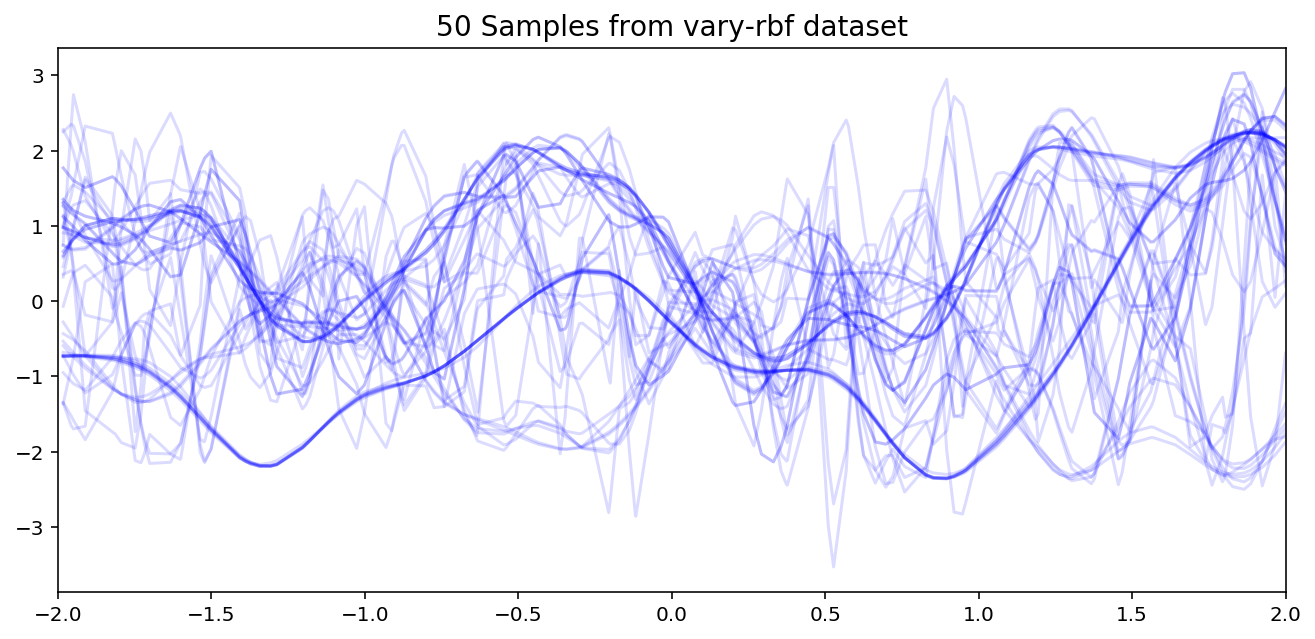

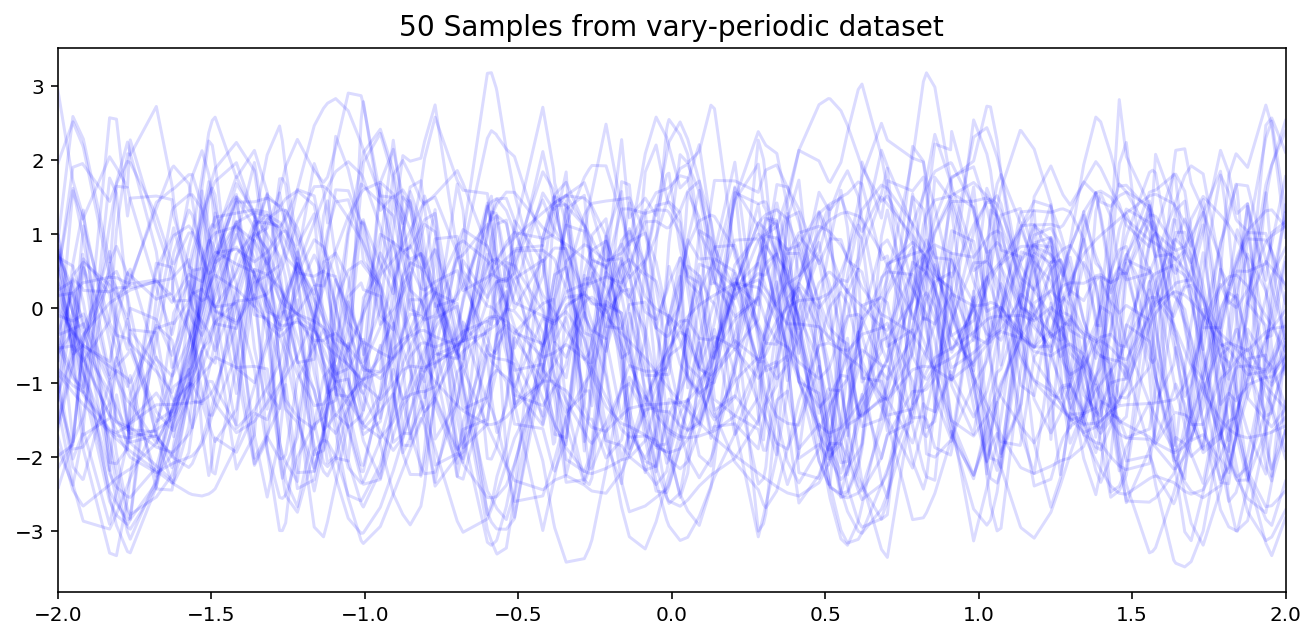

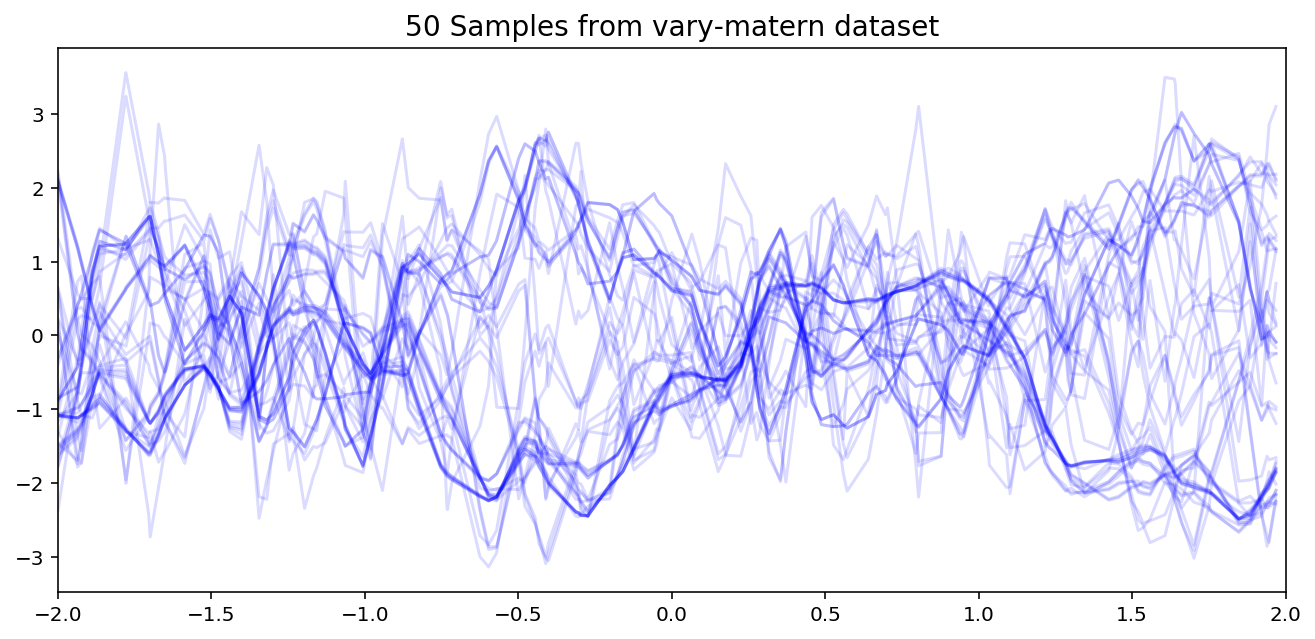

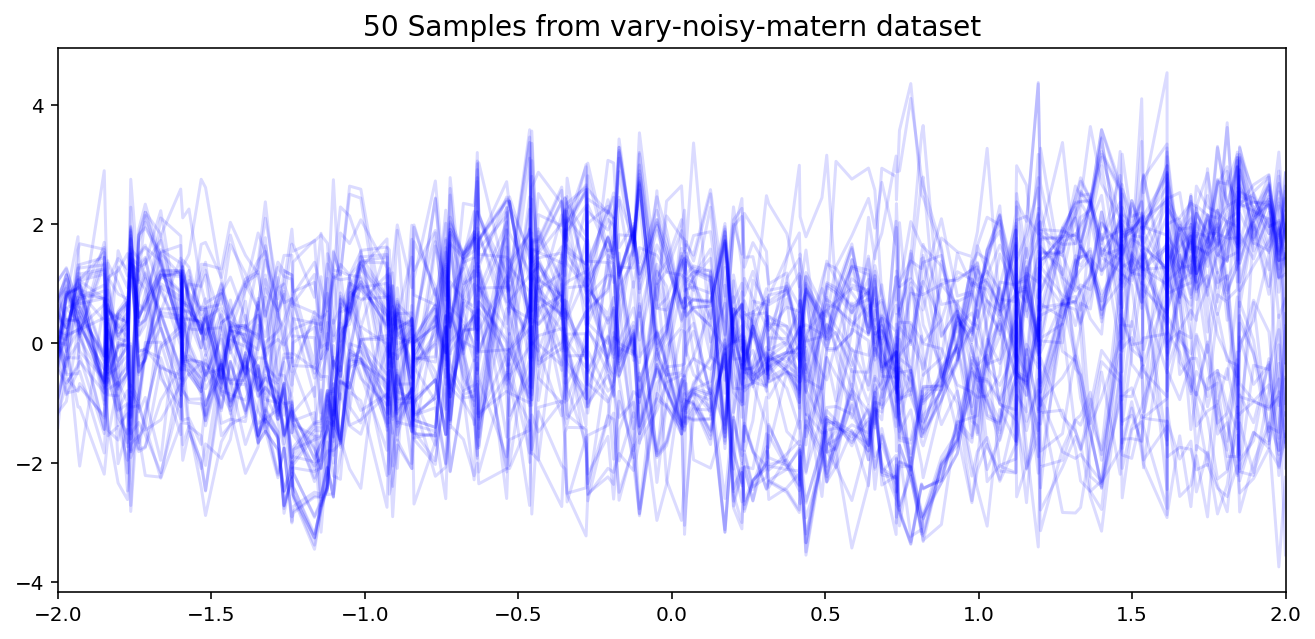

In [5]:
for k,v in datasets.items():
    plot_dataset_samples(v, title='50 Samples from {} dataset'.format(k), n_samples=50)

## Models Loading


In [6]:
import torch.nn as nn
from neuralproc import GlobalNeuralProcess, discard_ith_arg, AttentiveNeuralProcess
from neuralproc.utils.helpers import change_param, rescale_range, MultivariateNormalDiag
from neuralproc.utils.datasplit import (get_all_indcs, CntxtTrgtGetter, GetRandomIndcs, GetRangeIndcs,
                                        GetIndcsMerger, precomputed_cntxt_trgt_split)
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP
from neuralproc.utils.setcnn import SetConv,MlpRBF, GaussianRBF
from neuralproc.encoders import SinusoidalEncodings
from utils.helpers import count_parameters
from utils.datasets import cntxt_trgt_precompute
from ntbks_helpers import train_all_models_, get_percentile_converge_epoch, CNP_KWARGS

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

In [7]:
loaded = dict()

### Extended GNP Simple

In [8]:
model_name = "extended_gnp_simple"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, RadialBasisFunc=MlpRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=True,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1709Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 8952
Memory: 1709Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Unet

In [9]:
model_name = "extended_gnp_unet" 

gnp_kwargs = dict(r_dim=8,
                  keys_to_tmp_attn=change_param(SetConv, RadialBasisFunc=MlpRBF),
                  TmpSelfAttn=change_param(UnetCNN,
                                           Conv=torch.nn.Conv1d,
                                           Pool=torch.nn.MaxPool1d,
                                           upsample_mode="linear",
                                           n_layers=10,
                                           is_double_conv=True,
                                           bottleneck=None,
                                           is_depth_separable=True,
                                           Normalization=torch.nn.BatchNorm1d,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1021Mb")
   
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 8952
Memory: 1021Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---



/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=8 and input=1. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=2 and input=8. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))



--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Simple Only MLP

In [10]:
model_name = "extended_gnp_simple_only_mlp"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=MlpRBF),  # onyl diff with vanilla
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 3237Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 28660
Memory: 3237Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Simple Only Normalize

In [11]:
model_name = "extended_gnp_simple_only_normalize"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv,
                                                is_vanilla=False,  # onyl diff with vanilla
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv,
                                                   is_vanilla=False,  # onyl diff with vanilla
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 2677Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 28072
Memory: 2677Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Simple Only Depth Separable

In [12]:
model_name = "extended_gnp_simple_only_depthsep"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=True, # onyl diff with vanilla
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 2691Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 8356
Memory: 2691Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended ANP Sin

In [13]:
model_name = "extended_anp_sin"  

ANP_KWARGS = dict(get_cntxt_trgt=get_cntxt_trgt,
                  r_dim=32,
                  encoded_path="deterministic",  # use CNP
                  attention="weighted_dist",
                  XEncoder=SinusoidalEncodings,
                  is_relative_pos=False)

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **ANP_KWARGS), data)
               for name, data in datasets.items()}

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1103Mb") # mostly large due to the relative positions


  
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 11746
Memory: 1103Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended ANP Rel

In [14]:
model_name = "extended_anp_rel"  

ANP_KWARGS = dict(get_cntxt_trgt=get_cntxt_trgt,
                  r_dim=32,
                  encoded_path="deterministic", # use CNP
                  attention="transformer",
                  is_relative_pos=True) 

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **ANP_KWARGS), data)
               for name, data in datasets.items()}

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1301Mb") # mostly large due to the relative positions
  
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 18146
Memory: 1301Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Baseline

In [15]:
model_name = "baseline_rbf"   

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, 
                                                RadialBasisFunc=change_param(GaussianRBF, 
                                                                             max_dist_weight=0.7)),
                  TmpSelfAttn=None,
                  tmp_to_queries_attn=torch.nn.Identity,
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 629Mb")
     
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 4389
Memory: 629Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Vanilla ANP

In [16]:
model_name = "vanilla_anp"   

anp_kwargs = dict(r_dim=32,
                  get_cntxt_trgt=get_cntxt_trgt,
                  encoded_path="deterministic",
                  attention="multihead",
                  is_relative_pos=False)

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **anp_kwargs), data)
               for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 747Mb")
 
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 15970
Memory: 747Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Vanilla GNP

In [27]:
model_name = "vanilla_gnp" 

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 3403Mb")
   
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 28068
Memory: 3403Mb

--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



## Evaluation

### Quantitative

In [18]:
def score_cnp(trainer, dataset, get_cntxt_trgt=None, save_file=None, batch_size=512, n_test=100000, **kwargs):
    """Return the log likelihood"""
    score = 0
    n_steps = 0
    get_cntxt_trgt_old = trainer.module_.get_cntxt_trgt
    
    if get_cntxt_trgt is None:
        get_cntxt_trgt = trainer.module_.get_cntxt_trgt
    
    # when evealuating loss, use all targtes in that are not in context (but still sampel context)
    get_cntxt_trgt.set_eval()
        
    # use th eloss as metric (i.e. return log likelihood)
    trainer.criterion_.is_use_as_metric = True
    
    # only get sample from data if not already precomputed
    X_cntxt, Y_cntxt, X_trgt, Y_trgt = cntxt_trgt_precompute(lambda : dataset.get_samples(n_samples=n_test, **kwargs), 
                                                             get_cntxt_trgt, save_file)
    
    trainer.module_.get_cntxt_trgt = precomputed_cntxt_trgt_split
    
    for i in range(0, n_test, batch_size):
        n_steps += 1
        Xi_cntxt, Yi_cntxt, Xi_trgt, Yi_trgt = X_cntxt[i:i+batch_size], Y_cntxt[i:i+batch_size], X_trgt[i:i+batch_size], Y_trgt[i:i+batch_size]
        # puts in a skorch format (because y is splitted in the module itself)
        step = trainer.validation_step({"X":Xi_cntxt, "y":Yi_cntxt, "X_trgt":Xi_trgt, "y_trgt":Yi_trgt}, Yi_trgt)
        score += step["loss"].item()
       
        
    score /= n_steps
    
    get_cntxt_trgt.reset() # reset in case used in future
    
    trainer.module_.get_cntxt_trgt = get_cntxt_trgt_old
    
    return score 

In [19]:
def score_cnp_extrap(trainer, dataset, extrap_mode, extrap_distance=4, **kwargs):
    """Return the log likelihood of extrapolation."""
    interpolation_range = dataset.min_max
    extrapolation_range = (dataset.min_max[0], dataset.min_max[1] + extrap_distance)    

    extrap_rescaled_range = tuple(rescale_range(np.array(extrapolation_range), interpolation_range, (-1,1)))
    trainer.module_.set_extrapolation(extrap_rescaled_range) # set the model in extrapolation mode
    
    train_n_points = dataset.n_points
    total_n_points = int(rescale_range(dataset.n_points, interpolation_range, extrapolation_range))
    
    if extrap_mode == "shift":
        # shifting both the targets and context equally
        targets_getter = GetRangeIndcs((train_n_points, total_n_points))
        contexts_getter = GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5,
                                         range_indcs=(train_n_points, total_n_points))
        
    elif extrap_mode == "scale":
        # adding more context (making sure that keeping correct density for comparaison)
        contexts_getter = GetIndcsMerger([GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5, 
                                                         range_indcs=(0, train_n_points)),
                                          GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5, 
                                                         range_indcs=(train_n_points, total_n_points))])
        targets_getter = GetRangeIndcs((0, train_n_points))
        
        
    elif extrap_mode == "future":
        # predicting in the future => keeping same context but shifting targt
        contexts_getter = GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=.5, range_indcs=(0, train_n_points))
        targets_getter = GetRangeIndcs((train_n_points, total_n_points))
        
    else:
        raise ValueError("Unkown extrap_mode = {}.".format(extrap_mode))
        
    get_cntxt_trgt=CntxtTrgtGetter(contexts_getter=contexts_getter, 
                                   targets_getter=targets_getter, 
                                   is_add_cntxts_to_trgts=False)
    
    score = score_cnp(trainer, dataset, n_points=total_n_points, test_min_max=extrapolation_range, 
                      get_cntxt_trgt=get_cntxt_trgt, **kwargs)
    
    trainer.module_.set_extrapolation(interpolation_range) # put back to normal
    
    return score

In [20]:
def score_cnp_dense(trainer, dataset, **kwargs):
    """Return the log likelihood when increasing density."""
    
    # making sure that have high density by taking large context
    trainer.module_.get_cntxt_trgt.tmp_args["contexts_getter"] = GetRandomIndcs(min_n_indcs=.3, max_n_indcs=.7)
    
    # increase density by 100 and decrease test number by 10 (if not time ++), also decrease batchsize
    # for memory reasons
    score = score_cnp(trainer, dataset, n_points=dataset.n_points * 10, n_test=50000, batch_size=32, **kwargs)
    
    return score

In [21]:
import json

def make_all_summaries(loaded, save_file=None):
    """Return a dictionary of summaries: group -> data -> summary."""
    all_summaries = dict()
   
    for i, (model_name, loaded_group) in enumerate(loaded.items()):
        print()
        print("--- {} ---".format(model_name))
        all_summaries[model_name] = dict()
        for data_name, trainer in loaded_group["trainers"].items():
            print(data_name)
            history = trainer.history
            dataset = loaded_group["data_models"][data_name][1]
            
            converged_epoch = len(history)
            train_log_likelihood = - history[-1]["train_loss"]
            train_losses = [h['train_loss'] for h in history]
            percentile_converged_epoch = get_percentile_converge_epoch(history, percentile=0.1)
            time_per_epochs=sum(h['dur'] for h in history)/len(history)
            
            test_log_likelihood_interp = score_cnp(trainer, dataset, 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_interp".format(data_name)))
            test_log_likelihood_future = score_cnp_extrap(trainer, dataset, "future", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_future".format(data_name)))
            test_log_likelihood_scale = score_cnp_extrap(trainer, dataset, "scale", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_scale".format(data_name)))
            test_log_likelihood_shift = score_cnp_extrap(trainer, dataset, "shift", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_shift".format(data_name))) 
            
            try :
                test_log_likelihood_dense = score_cnp_dense(trainer, dataset, 
                                                            save_file=("data/gp_dataset.hdf5", "{}/test_dense".format(data_name)))
            except:
                print("issue with dense for", data_name)
                test_log_likelihood_dense = float("inf")
                
            all_summaries[model_name][data_name] = dict(converged_epoch = converged_epoch,
                                                       train_log_likelihood = train_log_likelihood,
                                                       percentile_converged_epoch = percentile_converged_epoch,
                                                       time_per_epochs = time_per_epochs,
                                                       test_log_likelihood_interp = test_log_likelihood_interp,
                                                       test_log_likelihood_future = test_log_likelihood_future,
                                                       test_log_likelihood_scale=test_log_likelihood_scale,
                                                        test_log_likelihood_shift=test_log_likelihood_shift,
                                                        test_log_likelihood_dense = test_log_likelihood_dense,
                                                       train_losses=train_losses) 
            
    if save_file is not None:
        if os.path.exists(save_file):
            os.rename(save_file, save_file+".bak")
            
        with open(save_file,"w") as f:
            json.dump(all_summaries, f)
        
    return all_summaries

In [22]:
import sklearn

def score_generator(dataset, get_cntxt_trgt=None, save_file=None, n_test=100000, **kwargs):
    """Return the log likelihood"""
    score = 0
    score_clamped = 0
    n_steps = 0
    generator = sklearn.base.clone(dataset.generator)
    
    # the intial param will be the correct value, which is cheating => randomly chose a new plausible intiial value
    for hyperparam in generator.kernel.hyperparameters:
        generator.kernel.set_params(**{hyperparam.name: np.random.uniform(*hyperparam.bounds.squeeze())})
    
    if get_cntxt_trgt is not None:
        # when evealuating loss, use all targtes in that are not in context (but still sampel context)
        get_cntxt_trgt.set_eval()
    
    # only get sample from data if not already precomputed
    X_cntxt, Y_cntxt, X_trgt, Y_trgt = cntxt_trgt_precompute(lambda : dataset.get_samples(n_samples=n_test, **kwargs), 
                                                             get_cntxt_trgt, save_file)
    
    # for generator should not be in -1 1
    X_cntxt = rescale_range(X_cntxt, (-1, 1), dataset.min_max).numpy()
    X_trgt = rescale_range(X_trgt, (-1, 1), dataset.min_max).numpy()
    Y_cntxt = Y_cntxt.numpy()
    Y_trgt = Y_trgt.double() # double precison for loss and leave in pytorch
    
    for i in range(n_test):
        Xi_cntxt, Yi_cntxt, Xi_trgt, Yi_trgt = X_cntxt[i], Y_cntxt[i], X_trgt[i], Y_trgt[i]
        generator.fit(Xi_cntxt, Yi_cntxt)
        mean_y, std_y = generator.predict(Xi_trgt, return_std=True)
        # use exact same loss as for CNP (could use scipy.stats.multivariate_normal.logpdf) but results differef
        m = MultivariateNormalDiag(torch.from_numpy(mean_y), torch.from_numpy(std_y)) 
        m_clamped = MultivariateNormalDiag(torch.from_numpy(mean_y), torch.from_numpy(std_y).clamp(min=0.1)) 
        score += m.log_prob(Yi_trgt).mean().item()
        score_clamped += m_clamped.log_prob(Yi_trgt).mean().item()
        break
        
    score /= n_test
    score_clamped /= n_test
    
    if get_cntxt_trgt is not None:
        get_cntxt_trgt.reset() # reset in case used in future
    
    return score, score_clamped

In [23]:
def add_generator_results(all_summaries, datasets, save_file=None):
    print("Computing Genrator results ...")
    all_summaries["Generator"] = dict()
    
    for k,dataset in datasets.items():
        test_log_likelihood_interp = score_generator(dataset, save_file=("data/gp_dataset.hdf5", "{}/test_interp".format(k)))
        test_log_likelihood_future = score_generator(dataset, save_file=("data/gp_dataset.hdf5", "{}/test_future".format(k)))
        test_log_likelihood_scale = score_generator(dataset, save_file=("data/gp_dataset.hdf5", "{}/test_scale".format(k)))
        test_log_likelihood_shift = score_generator(dataset, save_file=("data/gp_dataset.hdf5", "{}/test_shift".format(k))) 
        test_log_likelihood_dense = score_generator(dataset, save_file=("data/gp_dataset.hdf5", "{}/test_dense".format(k)))

        all_summaries["Generator"][k] = dict(
                                       test_log_likelihood_interp = test_log_likelihood_interp[0],
                                       test_log_likelihood_interp_clamped = test_log_likelihood_interp[1],
                                       test_log_likelihood_future = test_log_likelihood_future[0],
                                       test_log_likelihood_scale=test_log_likelihood_scale[0],
                                       test_log_likelihood_shift=test_log_likelihood_shift[0],
                                       test_log_likelihood_dense = test_log_likelihood_dense[0],
                                       test_log_likelihood_future_clamped = test_log_likelihood_future[1],
                                       test_log_likelihood_scale_clamped=test_log_likelihood_scale[1],
                                       test_log_likelihood_shift_clamped=test_log_likelihood_shift[1],
                                       test_log_likelihood_dense_clamped = test_log_likelihood_dense[1])
    
    if save_file is not None:
        if os.path.exists(save_file):
            os.rename(save_file, save_file+".bak")

    with open(save_file,"w") as f:
        json.dump(all_summaries, f)
    
    return all_summaries
    

In [36]:
%%time
all_summaries = make_all_summaries(loaded, save_file="results/attn_conv_compare/summaries_runk{}.json".format(k))


--- extended_gnp_simple ---
vary-rbf


INFO:utils.datasets.datasplit:Saving group vary-rbf/test_scale/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-rbf/test_shift/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-rbf/test_dense/ chunk None for future use ...


vary-periodic


INFO:utils.datasets.datasplit:Saving group vary-periodic/test_interp/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-periodic/test_future/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-periodic/test_scale/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-periodic/test_shift/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-periodic/test_dense/ chunk None for future use ...


vary-matern


INFO:utils.datasets.datasplit:Saving group vary-matern/test_interp/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-matern/test_future/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-matern/test_scale/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-matern/test_shift/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-matern/test_dense/ chunk None for future use ...


vary-noisy-matern


INFO:utils.datasets.datasplit:Saving group vary-noisy-matern/test_interp/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-noisy-matern/test_future/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-noisy-matern/test_scale/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-noisy-matern/test_shift/ chunk None for future use ...
INFO:utils.datasets.datasplit:Saving group vary-noisy-matern/test_dense/ chunk None for future use ...



--- extended_gnp_unet ---
vary-rbf
vary-periodic
vary-matern


KeyboardInterrupt: 

In [43]:
%%time
all_summaries = add_generator_results(all_summaries, datasets, 
                                      save_file="results/attn_conv_compare/summaries_runk{}_with_gen.json".format(k))

Computing Genrator results ...


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00025866]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


CPU times: user 30.7 s, sys: 16.7 s, total: 47.5 s
Wall time: 7.13 s


In [14]:
for group, summaries in all_summaries.items():
    print()
    print(group)
    for data, s in summaries.items():
        print("  ", data)
        for k,v in s.items():
            if k == 'train_losses':
                continue
            print("    ", k, ":", v)

### Qualitative

In [10]:
EXTRAP_DISTANCE = 4  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [11]:
for model_name, loaded_group in loaded.items():
    for k,(neural_proc, dataset) in loaded_group['data_models'].items():
        extrap_rescaled_range = tuple(rescale_range(np.array(EXTRAPOLATION_RANGE), (-2,2), (-1,1)))
        neural_proc.set_extrapolation(extrap_rescaled_range)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00128103]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


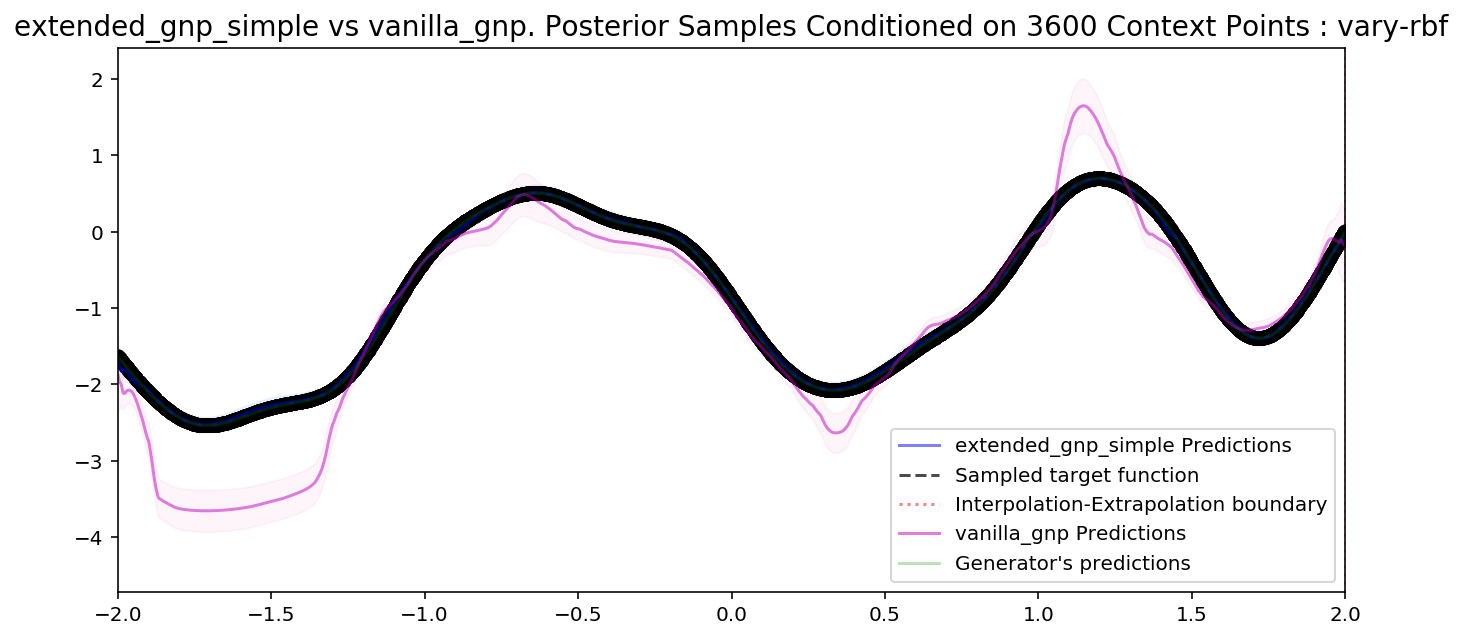

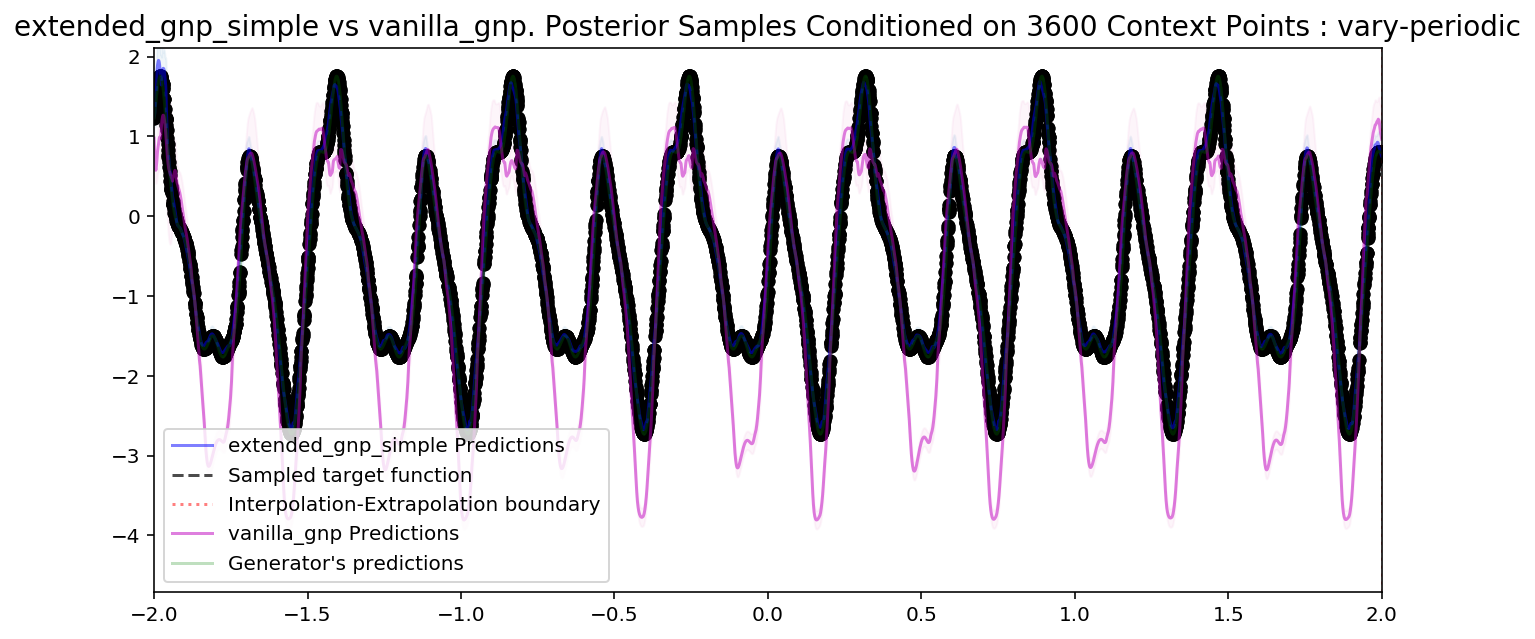

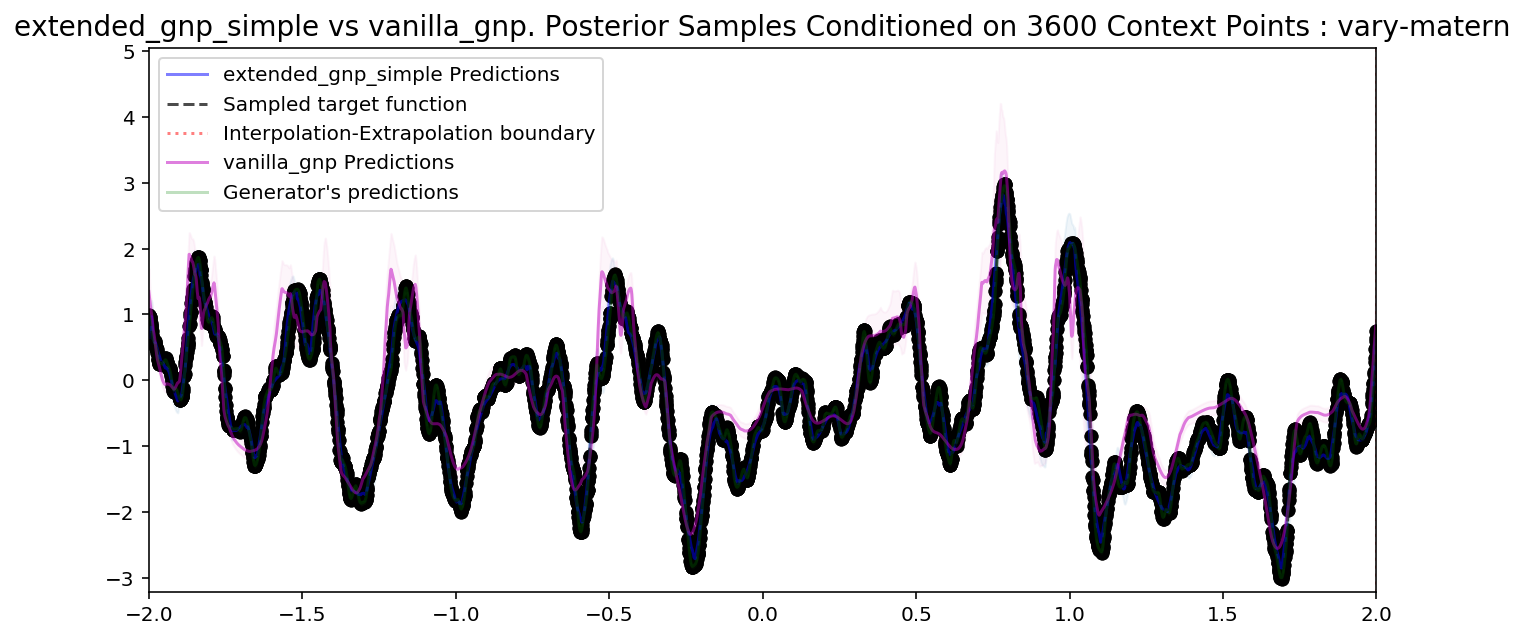

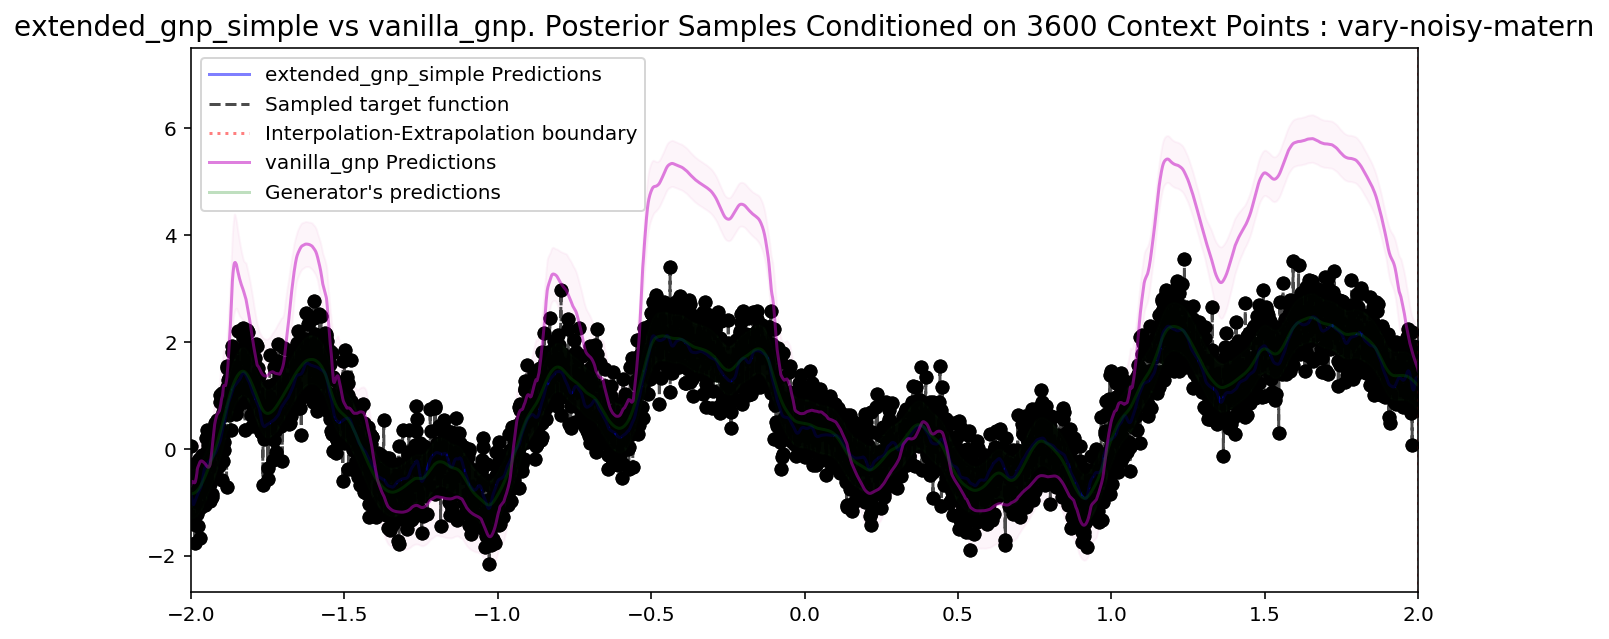

In [38]:
N_CNTXT = 3600

model1 = 'extended_gnp_simple'
model2 = 'vanilla_gnp'

for k,(neural_proc, dataset) in loaded[model1]['data_models'].items():
    
    plot_posterior_samples(dataset, neural_proc, 
                           compare_model=loaded[model2]['data_models'][k][0],
                           model_labels=[model1, model2],
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=N_CNTXT,
                           n_samples=1,
                           title="{} vs {}. Posterior Samples Conditioned on {} Context Points : {}".format(model1, model2, N_CNTXT, k))

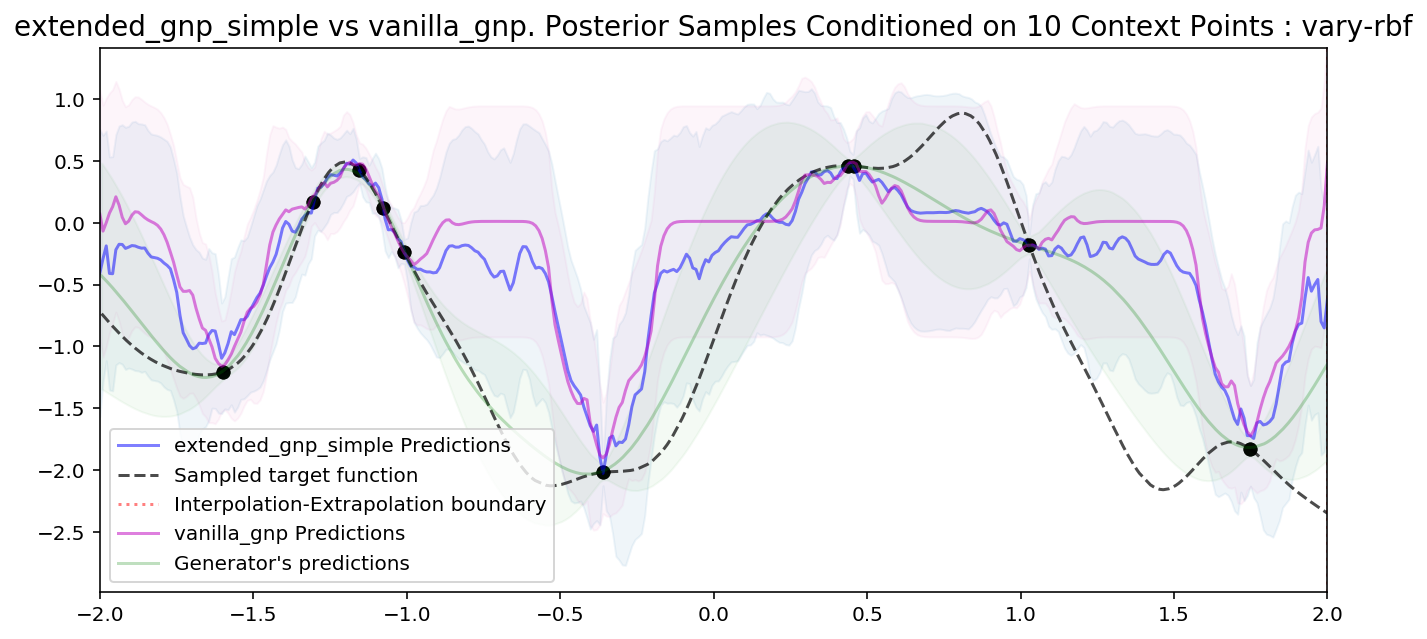

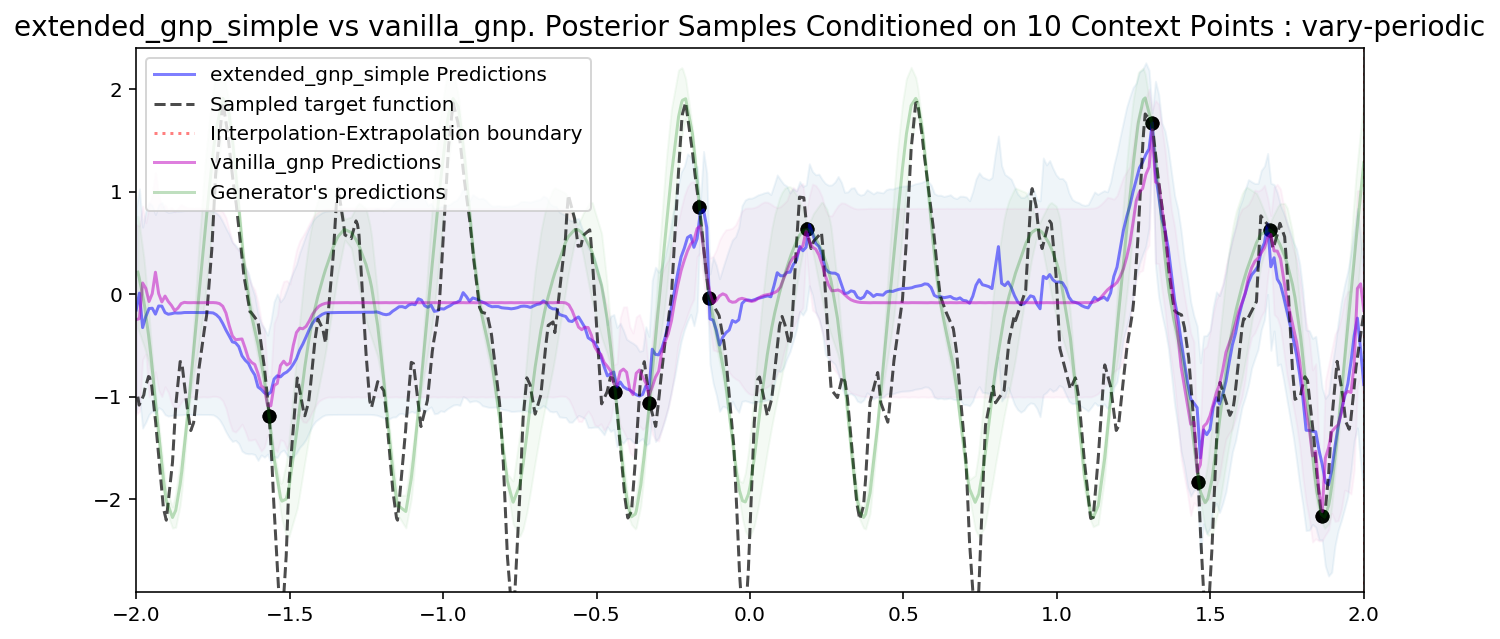

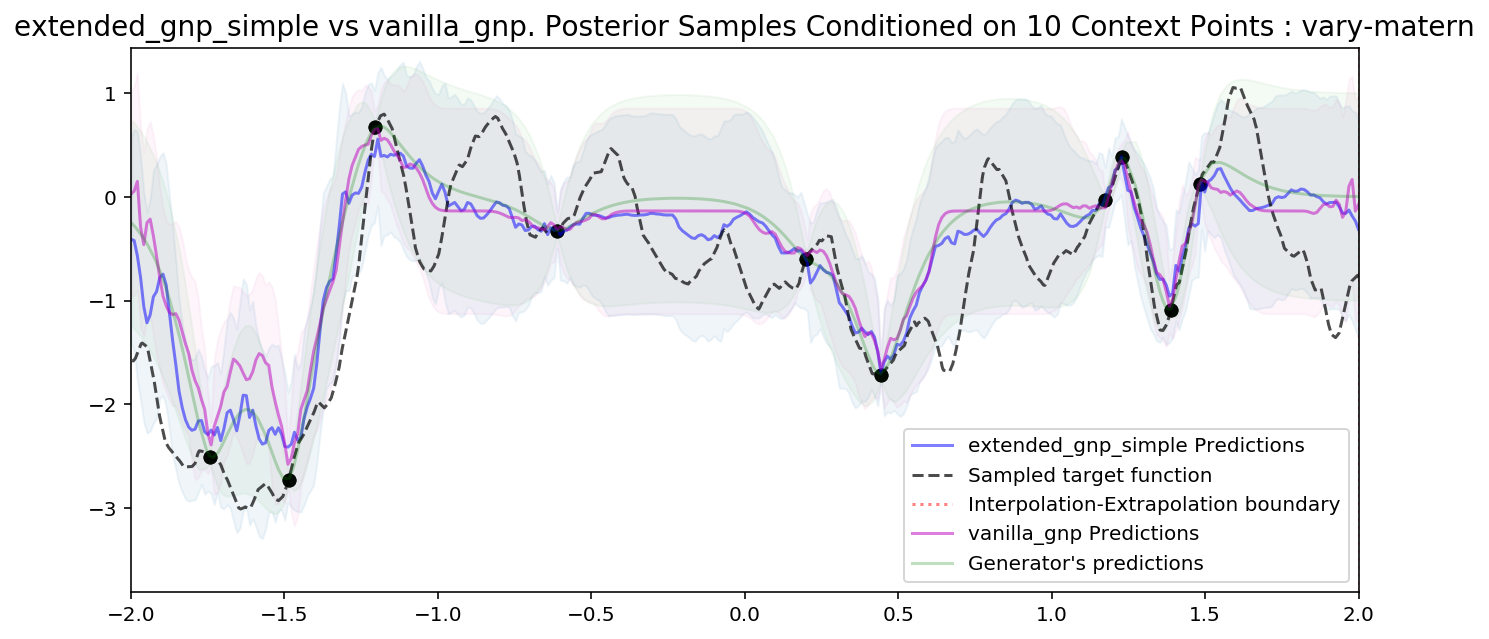

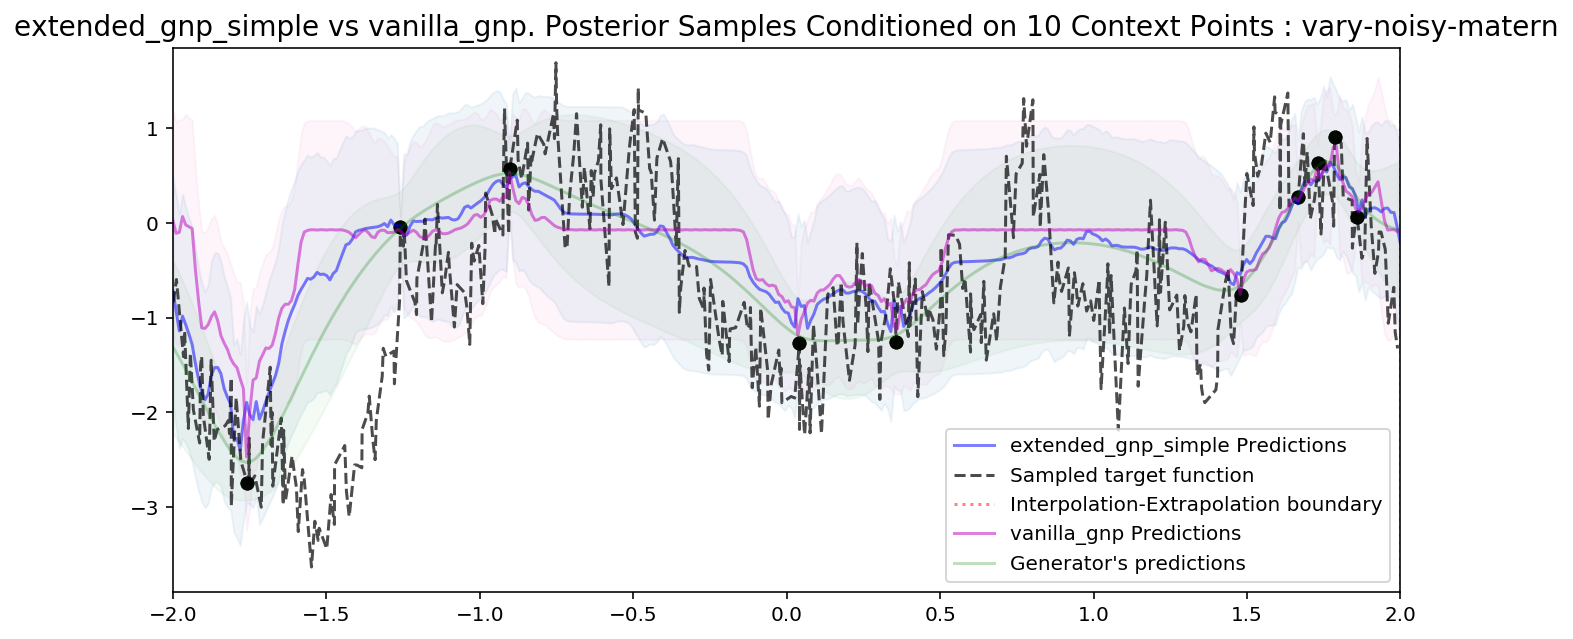

In [40]:
N_CNTXT = 10

model1 = 'extended_gnp_simple'
model2 = 'vanilla_gnp'

for k,(neural_proc, dataset) in loaded[model1]['data_models'].items():
    
    plot_posterior_samples(dataset, neural_proc, 
                           compare_model=loaded[model2]['data_models'][k][0],
                           model_labels=[model1, model2],
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="{} vs {}. Posterior Samples Conditioned on {} Context Points : {}".format(model1, model2, N_CNTXT, k))

In [149]:
import h5py
def plot_test(loaded, 
              model1='extended_gnp_simple',
              model_comp='vanilla_gnp',
              eg = 0,
              data_name='vary-matern', #'vary-matern', 'vary-rbf', 'vary-noisy-matern', 'vary-periodic'
              test_name='test_interp', #'test_dense', 'test_future', 'test_interp', 'test_scale', 'test_shift'
              extrap_dist = 4,
              dataset_plot_generator=None,
              **kwargs):
    
    with h5py.File("data/gp_dataset.hdf5", 'r') as hf:
        X_cntxt = hf['{}/{}/X_cntxt'.format(data_name, test_name)][eg:eg+1]
        Y_cntxt = hf['{}/{}/Y_cntxt'.format(data_name, test_name)][eg:eg+1]
        X_trgt = hf['{}/{}/X_trgt'.format(data_name, test_name)][eg:eg+1]
        Y_trgt = hf['{}/{}/Y_trgt'.format(data_name, test_name)][eg:eg+1]
        
    m=loaded[model1]['data_models'][data_name][0]
    
    print(X_cntxt.mean())
    
    
    extrap_range = (dataset.min_max[0], dataset.min_max[1]+extrap_dist )
    
    extrap_rescaled_range = tuple(rescale_range(np.array(extrap_range), (-2,2), (-1,1)))
    m.set_extrapolation(extrap_rescaled_range)
    alpha_init = 1 if model_comp is None else 0.5
    
    print(X_cntxt.shape)
    
    
    ax=plot_posterior_predefined_cntxt(m, 
                                true_func=(torch.from_numpy(X_trgt), torch.from_numpy(Y_trgt)),
                               X_cntxt=torch.from_numpy(X_cntxt), 
                               Y_cntxt=torch.from_numpy(Y_cntxt),
                               n_trgt=Y_trgt.shape[1],
                               n_samples=1,
                               is_plot_std=True,
                               train_min_max=(-2, 2),
                                       test_min_max=extrap_range,
                               title="Posterior Samples Conditioned : {} {}".format(test_name,data_name) ,
                                  model_label=model1, 
                                      alpha_init=alpha_init,
                                      **kwargs)
    
    if model_comp is not None:
        m_comp=loaded[model_comp]['data_models'][data_name][0]
        m_comp.set_extrapolation(extrap_rescaled_range)

        ax = plot_posterior_predefined_cntxt(m_comp, 
                                             X_cntxt=torch.from_numpy(X_cntxt), 
                                             Y_cntxt=torch.from_numpy(Y_cntxt),
                                             is_plot_std=True,
                                             train_min_max=(-2, 2),
                                             n_trgt=Y_trgt.shape[1],
                                             ax=ax,
                                             n_samples=1,
                                             test_min_max=extrap_range,
                                             is_comparing=True,
                                          model_label=model_comp, 
                                            alpha_init=alpha_init,
                                            **kwargs)
        
    if is_plot_generator:
        X_cntxt_plot = rescale_range(X_cntxt, (-1, 1), dataset.min_max).numpy()[0]
        # clones so doesn't change real generator => can still sample prior
        generator = sklearn.base.clone(dataset.generator)
        generator.fit(X_cntxt_plot, Y_cntxt.numpy()[0])
        X_trgt_plot = rescale_range(X, (-1, 1), dataset.min_max).numpy()[0].flatten()
        mean_y, std_y = generator.predict(X_trgt_plot[:, np.newaxis], return_std=True)
        mean_y = mean_y.flatten()
        ax.plot(X_trgt_plot, mean_y, alpha=alpha_init / 2, c="g", label="Generator's predictions")
        ax.fill_between(X_trgt_plot, mean_y - std_y, mean_y + std_y,
                        alpha=alpha_init / 10, color='tab:green')
        ax.legend()

0.014135676
(1, 695, 1)


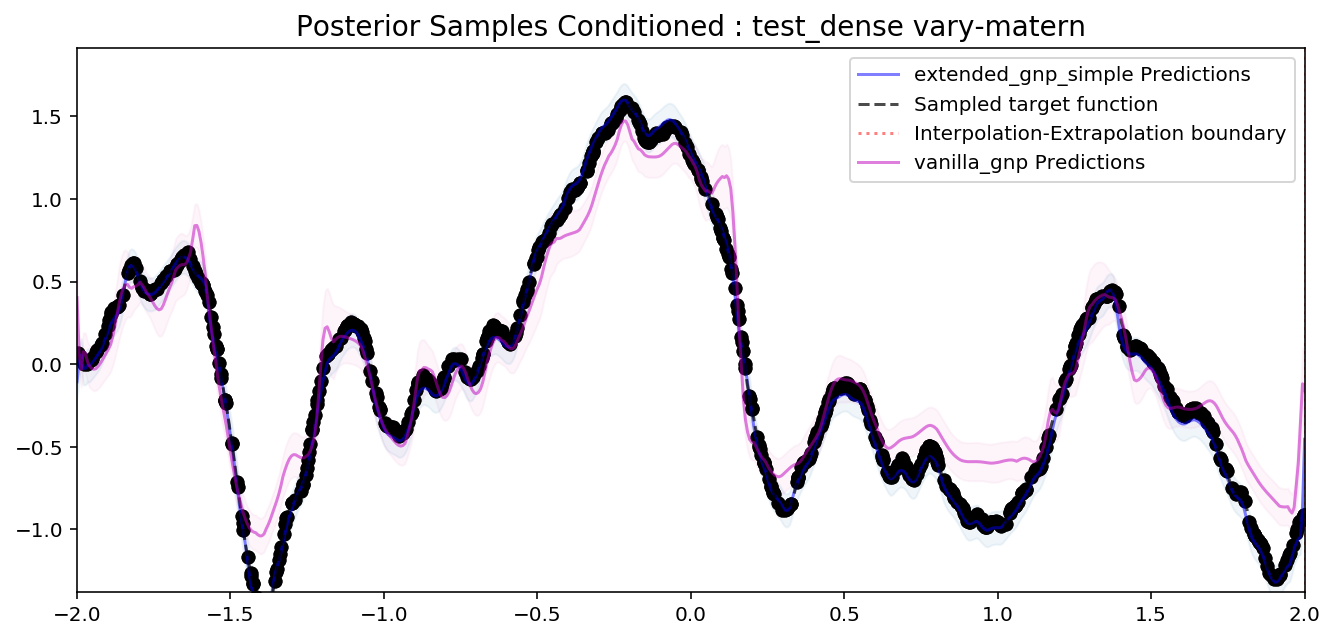

In [153]:
plot_test(loaded, test_name='test_dense', eg=1200, extrap_dist=0)

0.0054957056
(1, 59, 1)


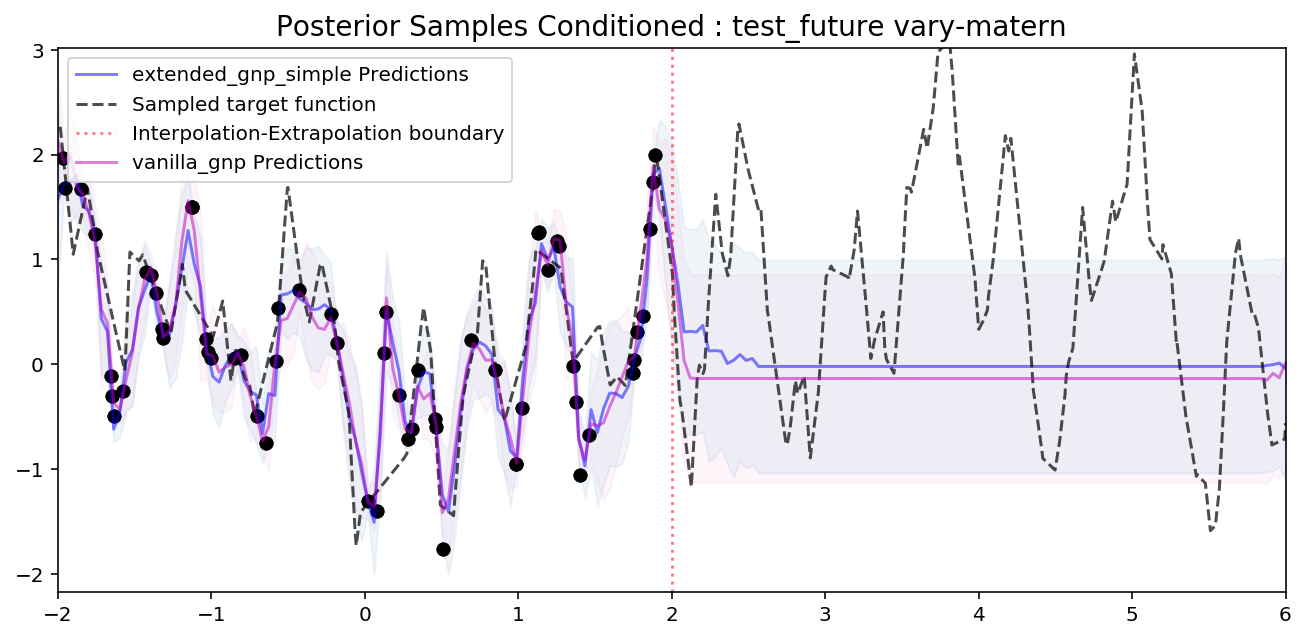

In [156]:
plot_test(loaded, test_name='test_future', eg=100)

(1, 49, 1)


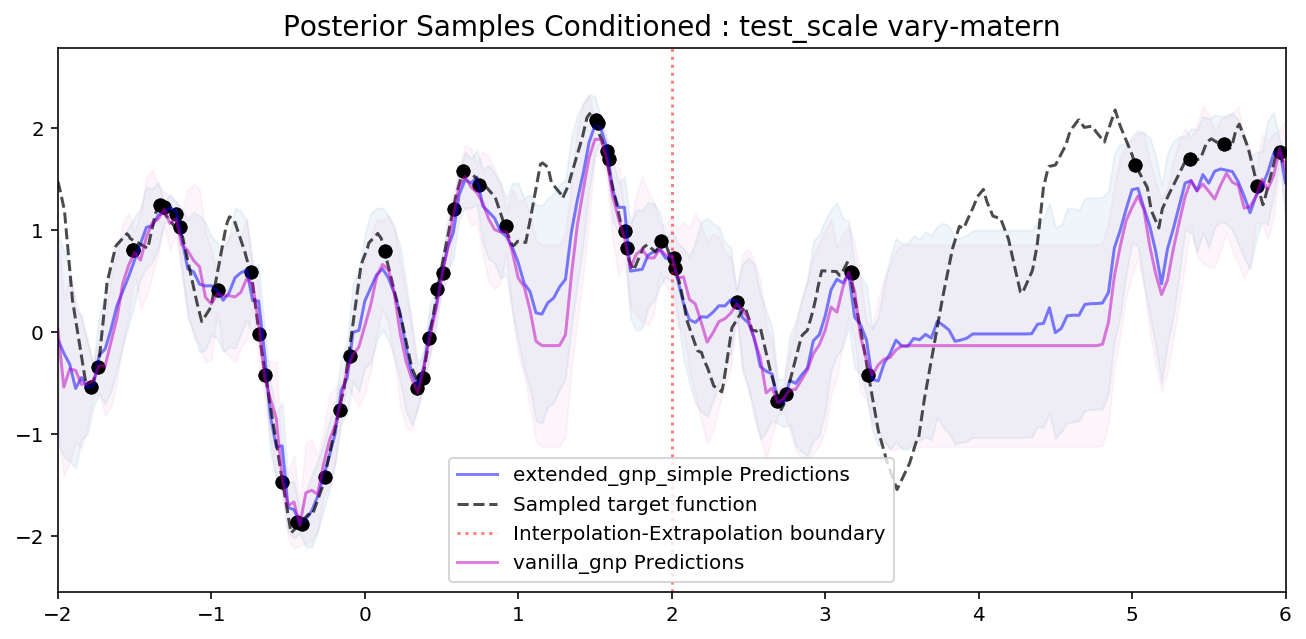

In [143]:
plot_test(loaded, test_name='test_scale', eg=1)

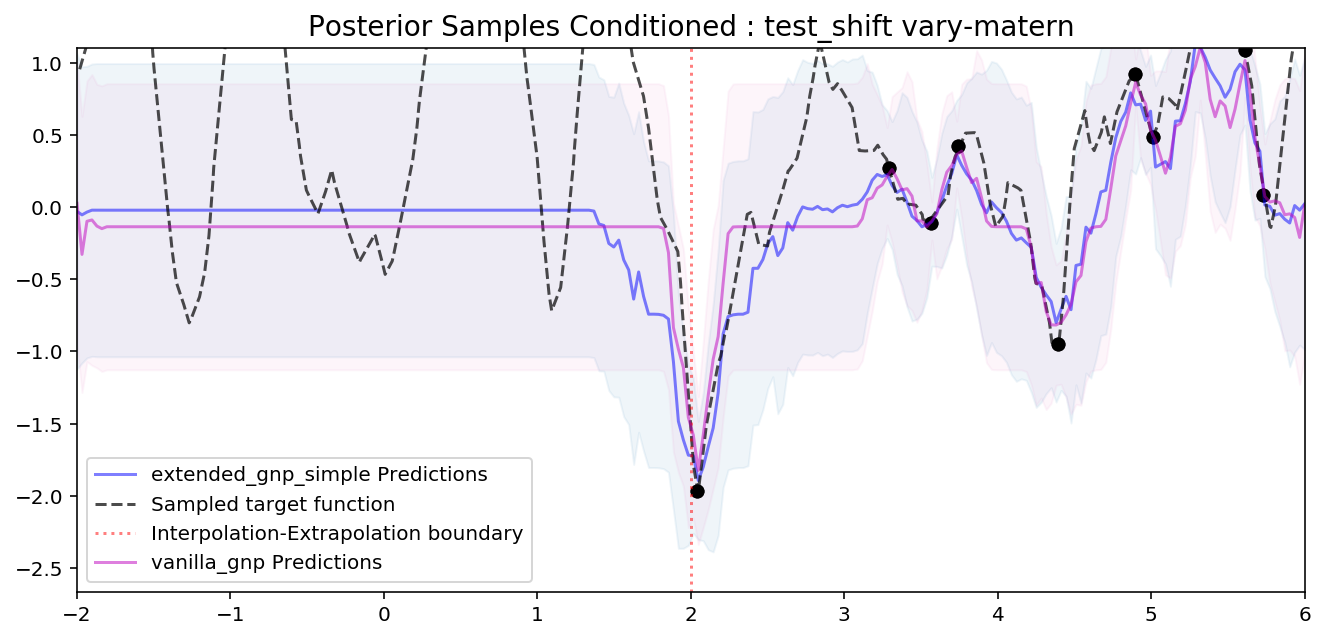

In [130]:
plot_test(loaded, test_name='test_shift', eg=1000)

In [ ]:
data_name = "vary-matern"
eg = 1200

import h5py
with h5py.File("data/gp_dataset.hdf5", 'r') as hf:
    print([k for k in hf[data_name].keys() if "test" in k])
    X_cntxt = hf['{}/test_dense/X_cntxt'.format(data_name)][eg:eg+1]
    Y_cntxt = hf['{}/test_dense/Y_cntxt'.format(data_name)][eg:eg+1]
    X_trgt = hf['{}/test_dense/X_trgt'.format(data_name)][eg:eg+1]
    Y_trgt = hf['{}/test_dense/Y_trgt'.format(data_name)][eg:eg+1]

In [ ]:
ax=plot_posterior_predefined_cntxt(m, 
                                true_func=(torch.from_numpy(X_trgt), torch.from_numpy(Y_trgt)),
                               X_cntxt=torch.from_numpy(X_cntxt), 
                               Y_cntxt=torch.from_numpy(Y_cntxt),
                               n_trgt=Y_trgt.shape[1],
                               n_samples=1,
                               is_plot_std=True,
                               train_min_max=(-1,1),
                               title="Posterior Samples Conditioned : Density Extrapolation",
                                  model_label=model1)

ax = plot_posterior_predefined_cntxt(m_comp, 
                                     X_cntxt=torch.from_numpy(X_cntxt), 
                                     Y_cntxt=torch.from_numpy(Y_cntxt),
                                     is_plot_std=True,
                                     train_min_max=(-1,1),
                                     n_trgt=Y_trgt.shape[1],
                                     ax=ax,
                                     n_samples=1,
                                     is_comparing=True,
                                  model_label=model_comp)